# Configuração

Iniciamos o código instalando as dependências e importanto as bibliotecas que serão utilizadas

In [ ]:
!pip uninstall numpy
!pip install numpy

!pip install pmdarima

Uninstalling numpy-1.19.5:
  Would remove:
    /usr/bin/f2py
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.7
    /usr/local/lib/python3.7/dist-packages/numpy-1.19.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libgfortran-2e0d59d6.so.5.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libopenblasp-r0-09e95953.3.13.so
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libquadmath-2d0c479f.so.0.0.0
    /usr/local/lib/python3.7/dist-packages/numpy.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.19.5
     |████████████████████████████████| 15.3MB 8.2MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have 

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 9.5MB 20.8MB/s 
     |████████████████████████████████| 14.8MB 286kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#Import modules
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from random import shuffle, choice
import datetime

import matplotlib
import statsmodels.api as sma
import statsmodels.graphics as smg
import statsmodels.tsa as smt
import statsmodels.tools as smtools

from pmdarima.arima import auto_arima


O código abaixo é responsável por instalar o pydrive que é uma biblioteca responsável por administrar arquivos do google drive. Após esta operação, os arquivos a serem utilizados são baixados para a máquina que está executando a aplicação.



In [ ]:
# Install lib to manage files from google drive
!pip install pydrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ID_FIELD = 'id'

# file id comes from the file url. For example, if you want to get file caso_full.csv,
# click to share file and you will get the url: https://drive.google.com/file/d/1c02g3Bb9SYYz1Ff5YjwpyqKzSGZSlfJS/view?usp=sharing
# the file_id is the character sequence after file/d/
file_id_sao_paulo = '1sFOaK30QCS3zTs4fxMYZzeBh6fKHpI9-'
file_name_sao_paulo = 'isolamento_sao_paulo.csv'
downloaded_sao_paulo = drive.CreateFile({ID_FIELD: file_id_sao_paulo})
downloaded_sao_paulo.GetContentFile(file_name_sao_paulo)

file_id_caso_full = '1v-aUkcJpWMg-DR9nAf9L48wba_7kA3h1'
file_name_caso_full = 'casos_sao_paulo.csv'
downloaded_caso_full = drive.CreateFile({ID_FIELD: file_id_caso_full})
downloaded_caso_full.GetContentFile(file_name_caso_full)

file_id_mobility = '1iwv-1JBJkVo3Ip-6fMq_ZQjxZyiB3PgP'
file_name_mobility = 'google_mobility.csv'
downloaded_mobility = drive.CreateFile({ID_FIELD: file_id_mobility})
downloaded_mobility.GetContentFile(file_name_mobility)

# Leitura do arquivo de isolamento

Iniciaremos lendo o arquivo de isolamento em são paulo

In [ ]:
isolamento_sao_paulo_data = pd.read_csv('isolamento_sao_paulo.csv', engine='python', sep=';')

NameError: ignored

Neste primeiro momento, a data não está convertido no formato esperado, então realizaremos esta operação.

In [ ]:
isolamento_sao_paulo_data.head(10)

NameError: ignored

Para converter a data, separamos a informação do dia da semana e a data. Então convertemos para a data utilizando o formato especificado. O ano não está presente, mas como a pandemia já superou um ano, então temos datas repetidas para a mesma cidade. Para resolver este problema, precisamos iterar cada linha e aplicar uma lógica para verificar se a data é 2020 ou 2021

In [ ]:
isolamento_sao_paulo_data[['dia da semana', 'data']] = isolamento_sao_paulo_data.Data.str.split(", ", expand=True)
isolamento_sao_paulo_data[['dia', 'mes']] = isolamento_sao_paulo_data.data.str.split("/", expand=True)

In [ ]:
isolamento_sao_paulo_data['dia'] = isolamento_sao_paulo_data['dia'].astype(int)
isolamento_sao_paulo_data['mes'] = isolamento_sao_paulo_data['mes'].astype(int)

In [ ]:
cidade_atual = 0
dia_convertido = dict()
for i, row in isolamento_sao_paulo_data.iterrows():
  if cidade_atual == 0 or cidade_atual != row[2]:
    dia_convertido.clear()
    cidade_atual = row[2]
  if (row.mes < 4 or (row.mes == 4 and row.dia < 7)):
    if row.mes in dia_convertido:
      if row.dia in dia_convertido[row.mes] or (row.mes == 2 and row.dia == 29):
        isolamento_sao_paulo_data.at[i, 'data'] = datetime.datetime(2020, row.mes, row.dia)
      else:
        isolamento_sao_paulo_data.at[i, 'data'] = datetime.datetime(2021, row.mes, row.dia)
        dia_convertido[row.mes][row.dia] = True
    else:
      dia_convertido[row.mes] = dict()
      dia_convertido[row.mes][row.dia] = True
      isolamento_sao_paulo_data.at[i, 'data'] = datetime.datetime(2021, row.mes, row.dia)
  else:
    isolamento_sao_paulo_data.at[i, 'data'] = datetime.datetime(2020, row.mes, row.dia)

In [ ]:
isolamento_sao_paulo_data.head(10)

,Munic�pio1,C�digo Munic�pio IBGE,Popula��o estimada (2020),UF1,Data,M�dia de �ndice De Isolamento,dia da semana,data,dia,mes
0,AMERICANA,3501608,242018,SP,"ter�a-feira, 06/04",40%,ter�a-feira,2021-04-06 00:00:00,6,4
1,AMERICANA,3501608,242018,SP,"segunda-feira, 05/04",40%,segunda-feira,2021-04-05 00:00:00,5,4
2,AMERICANA,3501608,242018,SP,"domingo, 04/04",49%,domingo,2021-04-04 00:00:00,4,4
3,AMERICANA,3501608,242018,SP,"s�bado, 03/04",44%,s�bado,2021-04-03 00:00:00,3,4
4,AMERICANA,3501608,242018,SP,"sexta-feira, 02/04",45%,sexta-feira,2021-04-02 00:00:00,2,4
5,AMERICANA,3501608,242018,SP,"quinta-feira, 01/04",38%,quinta-feira,2021-04-01 00:00:00,1,4
6,AMERICANA,3501608,242018,SP,"quarta-feira, 31/03",39%,quarta-feira,2021-03-31 00:00:00,31,3
7,AMERICANA,3501608,242018,SP,"ter�a-feira, 30/03",40%,ter�a-feira,2021-03-30 00:00:00,30,3
8,AMERICANA,3501608,242018,SP,"segunda-feira, 29/03",41%,segunda-feira,2021-03-29 00:00:00,29,3
9,AMERICANA,3501608,242018,SP,"domingo, 28/03",47%,domingo,2021-03-28 00:00:00,28,3


# Explorando os dados de isolamento em Campinas

## Leitura e pré-processamento dos dados de isolamento social

Neste momento utilizaremos o código de município do IBGE para selecionar apenas os dados de campinas

In [ ]:
booleans = isolamento_sao_paulo_data['C�digo Munic�pio IBGE'] == 3509502
filter_campinas = pd.Series(booleans)

In [ ]:
campinas_isolamento = isolamento_sao_paulo_data[filter_campinas]
campinas_isolamento.head(10)

,Munic�pio1,C�digo Munic�pio IBGE,Popula��o estimada (2020),UF1,Data,M�dia de �ndice De Isolamento,dia da semana,data,dia,mes
9598,CAMPINAS,3509502,1213792,SP,"ter�a-feira, 06/04",39%,ter�a-feira,2021-04-06 00:00:00,6,4
9599,CAMPINAS,3509502,1213792,SP,"segunda-feira, 05/04",39%,segunda-feira,2021-04-05 00:00:00,5,4
9600,CAMPINAS,3509502,1213792,SP,"domingo, 04/04",47%,domingo,2021-04-04 00:00:00,4,4
9601,CAMPINAS,3509502,1213792,SP,"s�bado, 03/04",43%,s�bado,2021-04-03 00:00:00,3,4
9602,CAMPINAS,3509502,1213792,SP,"sexta-feira, 02/04",43%,sexta-feira,2021-04-02 00:00:00,2,4
9603,CAMPINAS,3509502,1213792,SP,"quinta-feira, 01/04",37%,quinta-feira,2021-04-01 00:00:00,1,4
9604,CAMPINAS,3509502,1213792,SP,"quarta-feira, 31/03",38%,quarta-feira,2021-03-31 00:00:00,31,3
9605,CAMPINAS,3509502,1213792,SP,"ter�a-feira, 30/03",39%,ter�a-feira,2021-03-30 00:00:00,30,3
9606,CAMPINAS,3509502,1213792,SP,"segunda-feira, 29/03",40%,segunda-feira,2021-03-29 00:00:00,29,3
9607,CAMPINAS,3509502,1213792,SP,"domingo, 28/03",49%,domingo,2021-03-28 00:00:00,28,3


In [ ]:
colunas_interesse = ['data', 'M�dia de �ndice De Isolamento']
campinas_isolamento_filtrado = campinas_isolamento[colunas_interesse]
campinas_isolamento_filtrado

,data,M�dia de �ndice De Isolamento
9598,2021-04-06 00:00:00,39%
9599,2021-04-05 00:00:00,39%
9600,2021-04-04 00:00:00,47%
9601,2021-04-03 00:00:00,43%
9602,2021-04-02 00:00:00,43%
...,...,...
9996,2020-03-01 00:00:00,39%
9997,2020-02-29 00:00:00,35%
9998,2020-02-28 00:00:00,33%
9999,2020-02-27 00:00:00,33%


In [ ]:
campinas_isolamento_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 9598 to 10000
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   data                           403 non-null    object
 1   M�dia de �ndice De Isolamento  403 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


In [ ]:
campinas_isolamento_filtrado['M�dia de �ndice De Isolamento'] = campinas_isolamento_filtrado['M�dia de �ndice De Isolamento'].str.rstrip('%').astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Observando os dados para campinas, notamos que nem todas as datas tem dados, então precisamos complementar essas informações. No caso escolhemos o método para propagar o dado anterior e ajustamos a frequência para diária. Esta operação será necessária para realizar as análises da série temporal.

In [ ]:
campinas_isolamento_filtrado['data'] = campinas_isolamento_filtrado.loc[:, 'data'].astype('datetime64[ns]')
campinas_isolamento_filtrado = campinas_isolamento_filtrado.set_index("data")
campinas_isolamento_filtrado.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


DatetimeIndex(['2021-04-06', '2021-04-05', '2021-04-04', '2021-04-03',
               '2021-04-02', '2021-04-01', '2021-03-31', '2021-03-30',
               '2021-03-29', '2021-03-28',
               ...
               '2020-03-06', '2020-03-05', '2020-03-04', '2020-03-03',
               '2020-03-02', '2020-03-01', '2020-02-29', '2020-02-28',
               '2020-02-27', '2020-02-26'],
              dtype='datetime64[ns]', name='data', length=403, freq=None)

In [ ]:
campinas_isolamento_filtrado = campinas_isolamento_filtrado.sort_index().asfreq(freq='D', method='pad')
campinas_isolamento_filtrado.index

DatetimeIndex(['2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06',
               ...
               '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31',
               '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
               '2021-04-05', '2021-04-06'],
              dtype='datetime64[ns]', name='data', length=406, freq='D')

## Análise dos dados de isolamento social em campinas

Primeiramente, vamos criar um gráfico do índice de isolamento para cada dia

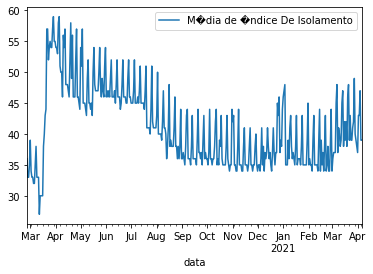

In [ ]:
campinas_isolamento_filtrado.plot()
plt.show()

Agora vamos analisar a propriedade de autocorrelação do índice de isolamento. Com esta propriedade, podemos verficar se os valores de isolamento podem ser expressadas pelos valores prévios.

O valor varia entre -1 e 1, sendo que 1 signfica que é perfeitamente correlacionado, -1 é perfeitamente correlacionado negativamente e 0 significa que não tem correlação. O primeiro valor sempre é 1 e a região em azul representa a confiancia no valor, portanto apenas os valores fora da faixa azul é significativo.

A autocorrelação (primeira figura) é a correlação entre seus valores passados e futuros. A autocorrelação parcial (segunda figura) é a correlação entre a série temporal e seus valores deslocados, ou seja, a relação entre o valor de um ponto no tempo com um outro ponto no passado.

Ao analisar o índice para a cidade de Campinas, podemos notar que a autocorrelação é significativa até a 17a posição e a autocorrelação parcial é até a 10a posição. Importante observar que após a 10a posição, temos valores significativos na 14a, 15a, 21a e 22a posição. Estes valores podem ser relacionadas com os dias da semana.



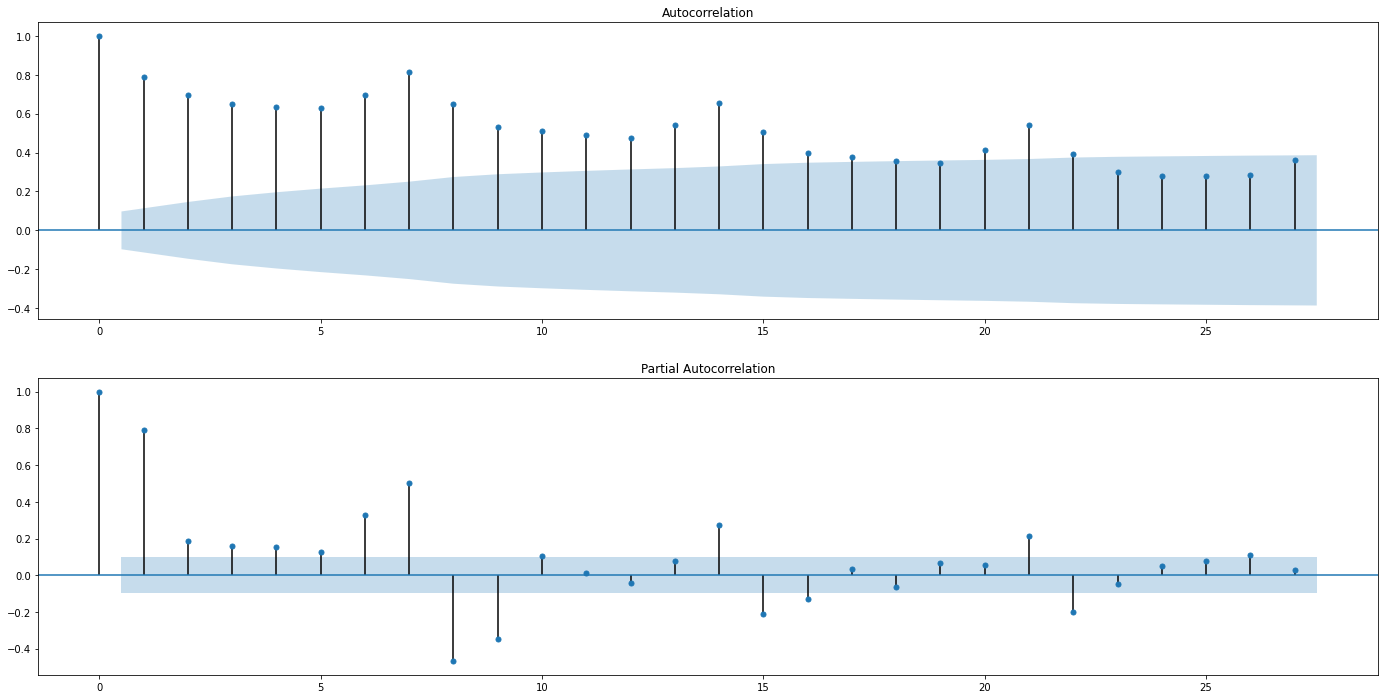

In [ ]:
fig, ax = plt.subplots(2, figsize=(24, 12))
ax[0] = smg.tsaplots.plot_acf(campinas_isolamento_filtrado, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(campinas_isolamento_filtrado, ax=ax[1])

Agora vamos analisar os padrões da série temporal do isolamento social.

O tendência (Trend) descreve o comportamento geral. O padrão sazonal (Seasonal) descreve as flutuações causadas por eventos relacionados ao calendário. O residual é o resto da série temporal removendo a tendência e o padrão sazonal. O resíduo é esperado que seja o menor possível.

<function matplotlib.pyplot.show>

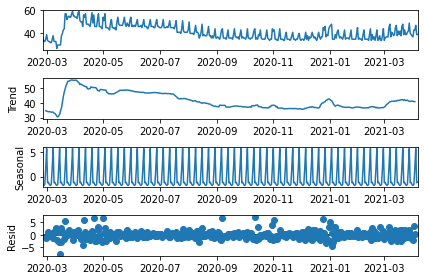

In [ ]:
decomposition_campinas_isolamento_filtrado = sma.tsa.seasonal_decompose(campinas_isolamento_filtrado_data)
fig_decomposition = decomposition_campinas_isolamento_filtrado.plot()
plt.show

# Leitura de dados de isolamento do Google

https://www.google.com/covid19/mobility/data_documentation.html?hl=en

In [ ]:
mobility_data = pd.read_csv(file_name_mobility)
mobility_data.head(10)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-15,5.0,4.0,-5.0,8.0,6.0,0.0
1,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-16,2.0,3.0,-13.0,3.0,0.0,1.0
2,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-17,-2.0,0.0,-12.0,9.0,19.0,-1.0
3,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-18,-3.0,-1.0,-11.0,9.0,15.0,-1.0
4,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-19,-1.0,-2.0,-5.0,8.0,14.0,-1.0
5,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-20,1.0,7.0,2.0,11.0,15.0,-2.0
6,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-21,2.0,10.0,1.0,12.0,13.0,-1.0
7,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-22,-3.0,6.0,12.0,6.0,-4.0,0.0
8,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-23,4.0,7.0,32.0,2.0,-3.0,1.0
9,BR,Brazil,NaN,NaN,NaN,NaN,NaN,ChIJzyjM68dZnAARYz4p8gYVWik,2020-02-24,-14.0,-7.0,69.0,-27.0,-45.0,8.0


In [ ]:
mobility_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590689 entries, 0 to 590688
Data columns (total 15 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   country_region_code                                 590689 non-null  object 
 1   country_region                                      590689 non-null  object 
 2   sub_region_1                                        590368 non-null  object 
 3   sub_region_2                                        581701 non-null  object 
 4   metro_area                                          0 non-null       float64
 5   iso_3166_2_code                                     8667 non-null    object 
 6   census_fips_code                                    0 non-null       float64
 7   place_id                                            590689 non-null  object 
 8   date                                                590689 non-n

# Explorando dados de campinas

In [ ]:
booleans = mobility_data['sub_region_2'] == 'Campinas'
booleans

0         False
1         False
2         False
3         False
4         False
          ...  
590684    False
590685    False
590686    False
590687    False
590688    False
Name: sub_region_2, Length: 590689, dtype: bool

In [ ]:
filter = pd.Series(booleans)
mobility_campinas = mobility_data[filter]
mobility_campinas.head(5)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
488214,BR,Brazil,State of São Paulo,Campinas,NaN,NaN,NaN,ChIJSSZVovbIyJQRNjUEWBwAdXQ,2020-02-15,4.0,8.0,37.0,3.0,5.0,-1.0
488215,BR,Brazil,State of São Paulo,Campinas,NaN,NaN,NaN,ChIJSSZVovbIyJQRNjUEWBwAdXQ,2020-02-16,-2.0,9.0,25.0,0.0,1.0,0.0
488216,BR,Brazil,State of São Paulo,Campinas,NaN,NaN,NaN,ChIJSSZVovbIyJQRNjUEWBwAdXQ,2020-02-17,-10.0,2.0,0.0,1.0,16.0,-2.0
488217,BR,Brazil,State of São Paulo,Campinas,NaN,NaN,NaN,ChIJSSZVovbIyJQRNjUEWBwAdXQ,2020-02-18,-7.0,3.0,11.0,2.0,13.0,-2.0
488218,BR,Brazil,State of São Paulo,Campinas,NaN,NaN,NaN,ChIJSSZVovbIyJQRNjUEWBwAdXQ,2020-02-19,-8.0,1.0,-7.0,0.0,12.0,-1.0


## Explorando dados de varejo e recriação

Nesta seção exploraremos a tendência de mobilidade para locais como restaurantes, cafés, shopping centers, parques temáticos, museus, bibliotecas e cinema.

In [ ]:
cols_retail_recreation = ['date', 'retail_and_recreation_percent_change_from_baseline']
mobility_campinas_retail = mobility_campinas[cols_retail_recreation]
mobility_campinas_retail.head(5)

,date,retail_and_recreation_percent_change_from_baseline
488214,2020-02-15,4.0
488215,2020-02-16,-2.0
488216,2020-02-17,-10.0
488217,2020-02-18,-7.0
488218,2020-02-19,-8.0


In [ ]:
mobility_campinas_retail['date'] = mobility_campinas_retail.loc[:,'date'].astype('datetime64[ns]')
mobility_campinas_retail = mobility_campinas_retail.set_index('date')
mobility_campinas_retail.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


DatetimeIndex(['2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=321, freq=None)

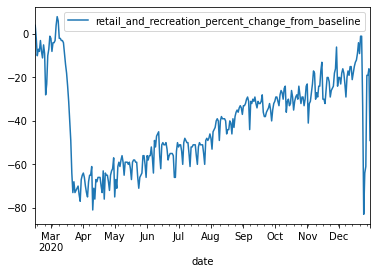

In [ ]:
mobility_campinas_retail.plot()
plt.show()

Analisando a autocorrelação, percebemos que os dados são significativoss até o 18o dia. A autocorrelação parcial é significativo apenas até o 1o dia.

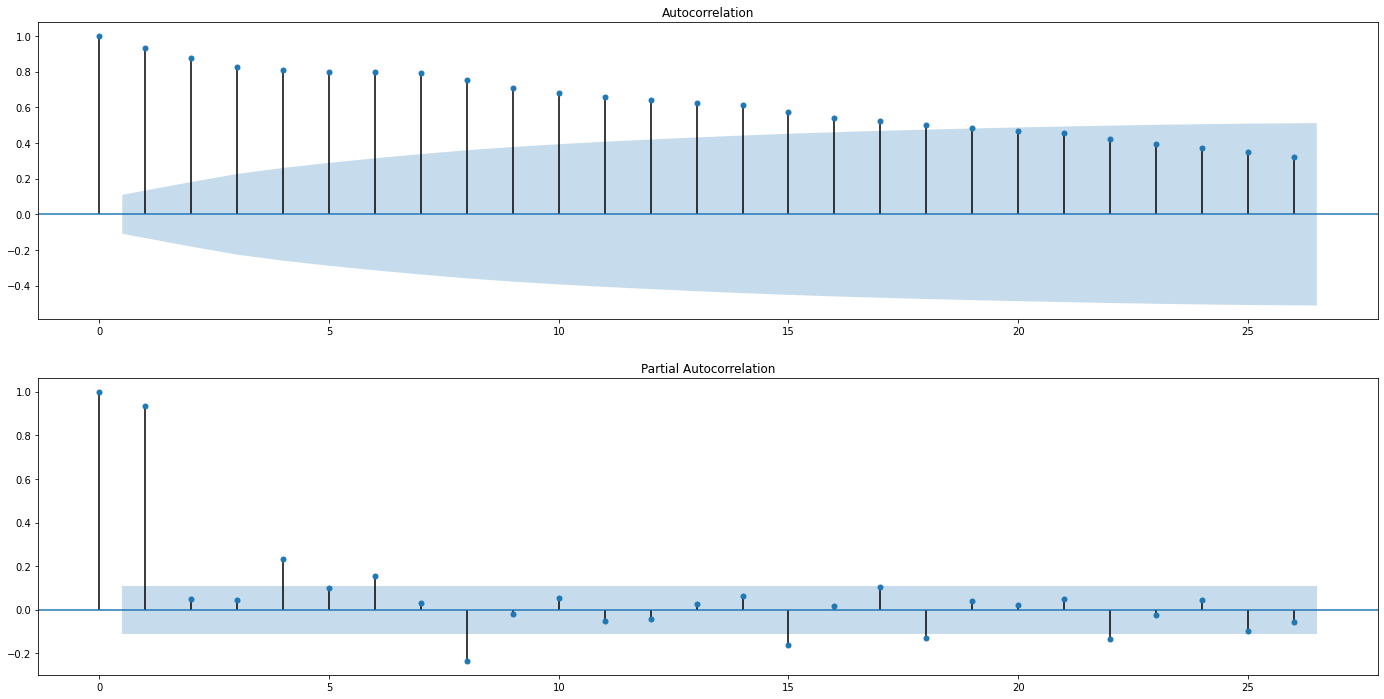

In [ ]:
fig, ax = plt.subplots(2, figsize=(24,12))
ax[0] = smg.tsaplots.plot_acf(mobility_campinas_retail, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(mobility_campinas_retail, ax=ax[1])

Podemos observar que existe uma tendência de crescimento e um fator sazonal.

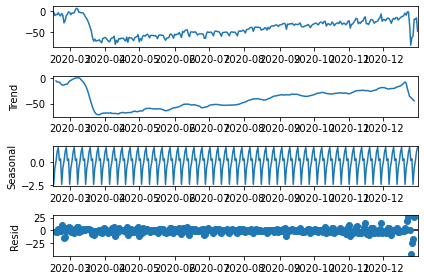

In [ ]:
decomposition_confirmed = sma.tsa.seasonal_decompose(mobility_campinas_retail)
fig_dec_confirmed = decomposition_confirmed.plot()
plt.show()

## Mobilidade para mercados e farmácias

O próximo dado de mobilidade analisada será composta por mercados, feiras e farmácias.

In [ ]:
cols_grocery = ['date', 'grocery_and_pharmacy_percent_change_from_baseline']
mobility_campinas_grocery = mobility_campinas[cols_grocery]
mobility_campinas_grocery.head(5)

,date,grocery_and_pharmacy_percent_change_from_baseline
488214,2020-02-15,8.0
488215,2020-02-16,9.0
488216,2020-02-17,2.0
488217,2020-02-18,3.0
488218,2020-02-19,1.0


In [ ]:
mobility_campinas_grocery['date'] = mobility_campinas_grocery.loc[:, 'date'].astype('datetime64[ns]')
mobility_campinas_grocery = mobility_campinas_grocery.set_index('date')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


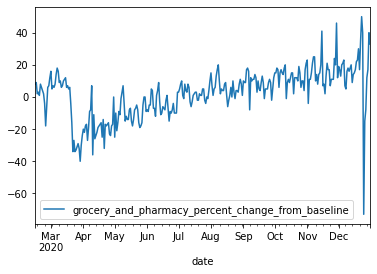

In [ ]:
mobility_campinas_grocery.plot()
plt.show()

A autocorrelação é significativa até o 22o dia. A parcial é significativa até o 2o dia.

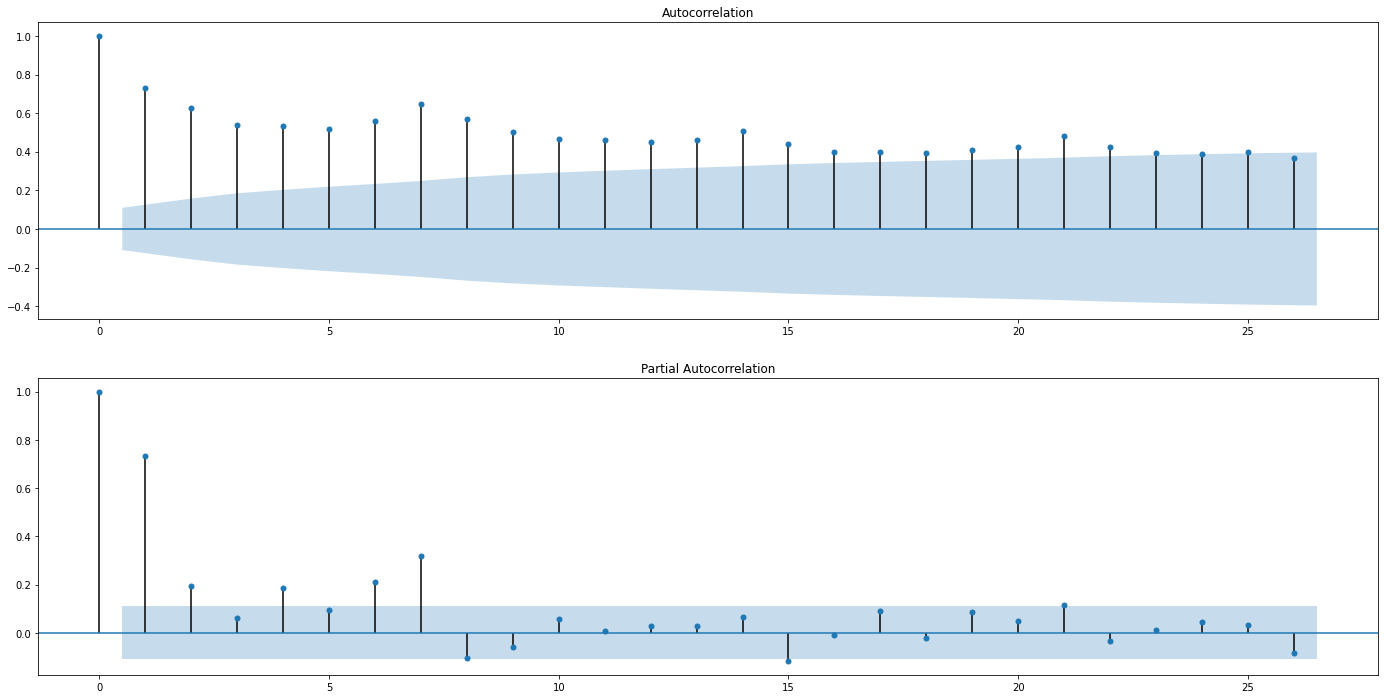

In [ ]:
fig, ax = plt.subplots(2, figsize=(24,12))
ax[0] = smg.tsaplots.plot_acf(mobility_campinas_grocery, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(mobility_campinas_grocery, ax=ax[1])

Podemos observar uma tendência e a presença de sazonalidade.

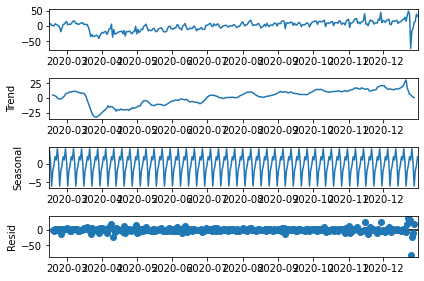

In [ ]:
decomposition_confirmed = sma.tsa.seasonal_decompose(mobility_campinas_grocery)
fig_dec_confirmed = decomposition_confirmed.plot()
plt.show()

## Mobilidade em parques

Nesta seção observaremos a mobilidade para parques locais, nacionais, praias, parques para cachorros e jardins públicos.

In [ ]:
cols_parks = ["date", "parks_percent_change_from_baseline"]
mobility_campinas_park = mobility_campinas[cols_parks]
mobility_campinas_park.head(5)

,date,parks_percent_change_from_baseline
488214,2020-02-15,37.0
488215,2020-02-16,25.0
488216,2020-02-17,0.0
488217,2020-02-18,11.0
488218,2020-02-19,-7.0


In [ ]:
mobility_campinas_park['date'] = mobility_campinas_park.loc[:,'date'].astype('datetime64[ns]')
mobility_campinas_park = mobility_campinas_park.set_index("date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


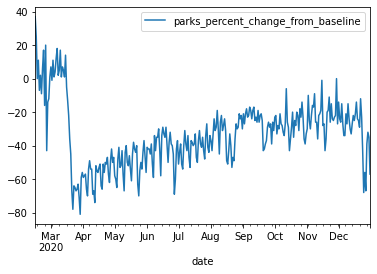

In [ ]:
mobility_campinas_park.plot()
plt.show()

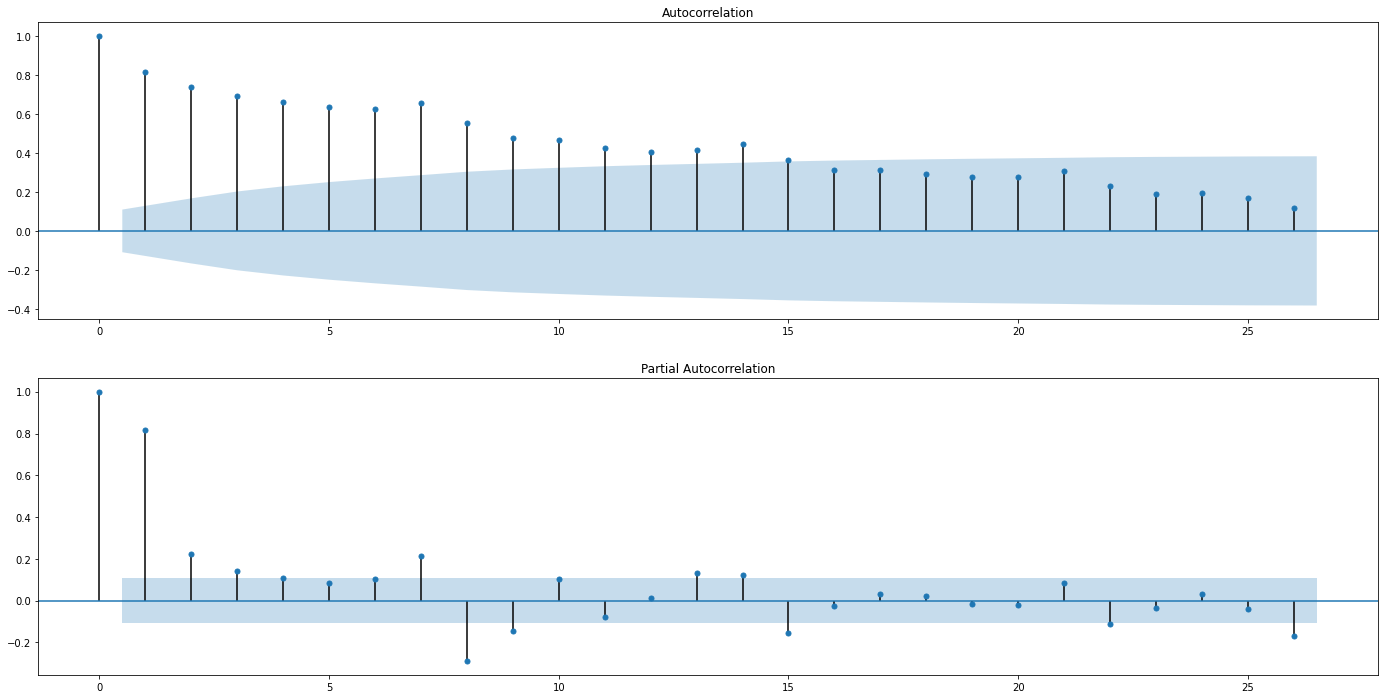

In [ ]:
fig, ax = plt.subplots(2, figsize=(24,12))
ax[0] = smg.tsaplots.plot_acf(mobility_campinas_park, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(mobility_campinas_park, ax=ax[1])

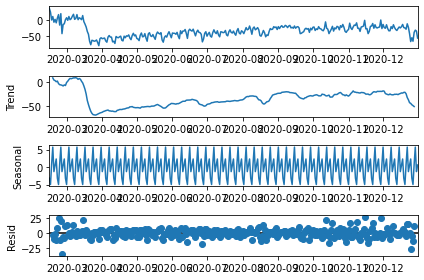

In [ ]:
decomposition_confirmed = sma.tsa.seasonal_decompose(mobility_campinas_park)
fig_dec_confirmed = decomposition_confirmed.plot()
plt.show()

## Mobilidade em estações de transporte público

Nesta seção observaremos os dados de mobilidade para pontos de transportes públicos como estações e paradas de metrô, ônibus e trem.

In [ ]:
cols_transit = ["date", "transit_stations_percent_change_from_baseline"]
mobility_campinas_transit = mobility_campinas[cols_transit]
mobility_campinas_transit.head(5)

,date,transit_stations_percent_change_from_baseline
488214,2020-02-15,3.0
488215,2020-02-16,0.0
488216,2020-02-17,1.0
488217,2020-02-18,2.0
488218,2020-02-19,0.0


In [ ]:
mobility_campinas_transit['date'] = mobility_campinas_transit.loc[:,'date'].astype('datetime64[ns]')
mobility_campinas_transit = mobility_campinas_transit.set_index("date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


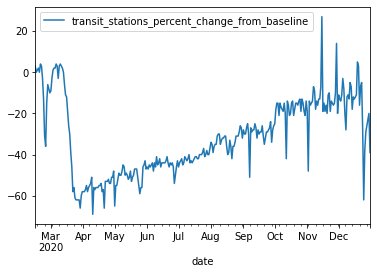

In [ ]:
mobility_campinas_transit.plot()
plt.show()

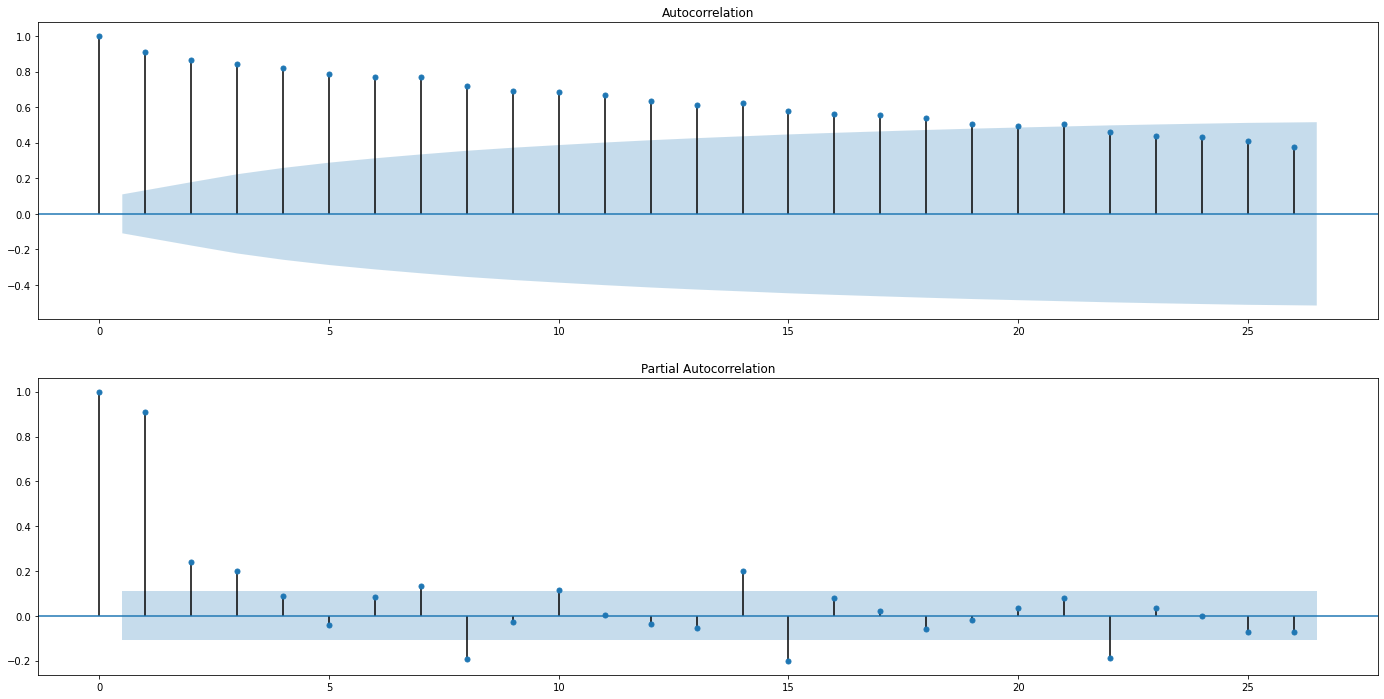

In [ ]:
fig, ax = plt.subplots(2, figsize=(24,12))
ax[0] = smg.tsaplots.plot_acf(mobility_campinas_transit, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(mobility_campinas_transit, ax=ax[1])

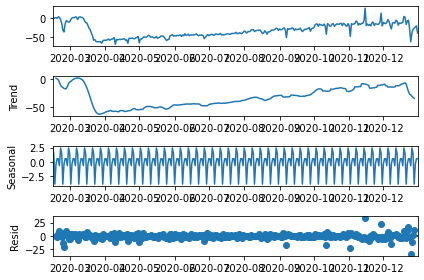

In [ ]:
decomposition_confirmed = sma.tsa.seasonal_decompose(mobility_campinas_transit)
fig_dec_confirmed = decomposition_confirmed.plot()
plt.show()

## Mobilidade para o local de trabalho

Nesta seção analisaremos a mobilidade para os locais de trabalho.

In [ ]:
cols_workplace = ["date", "workplaces_percent_change_from_baseline"]
mobility_campinas_workplace = mobility_campinas[cols_workplace]
mobility_campinas_workplace.head(5)

,date,workplaces_percent_change_from_baseline
488214,2020-02-15,5.0
488215,2020-02-16,1.0
488216,2020-02-17,16.0
488217,2020-02-18,13.0
488218,2020-02-19,12.0


In [ ]:
mobility_campinas_workplace['date'] = mobility_campinas_workplace.loc[:,'date'].astype('datetime64[ns]')
mobility_campinas_workplace = mobility_campinas_workplace.set_index("date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


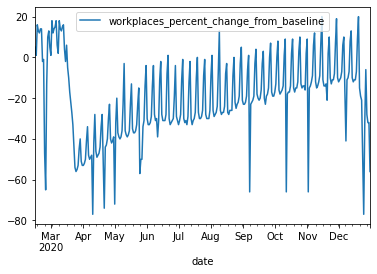

In [ ]:
mobility_campinas_workplace.plot()
plt.show()

A autocorrelação para o local de trabalho é um dos menores (11a posição), mas ainda podemos observar que é autocorrelacionado.

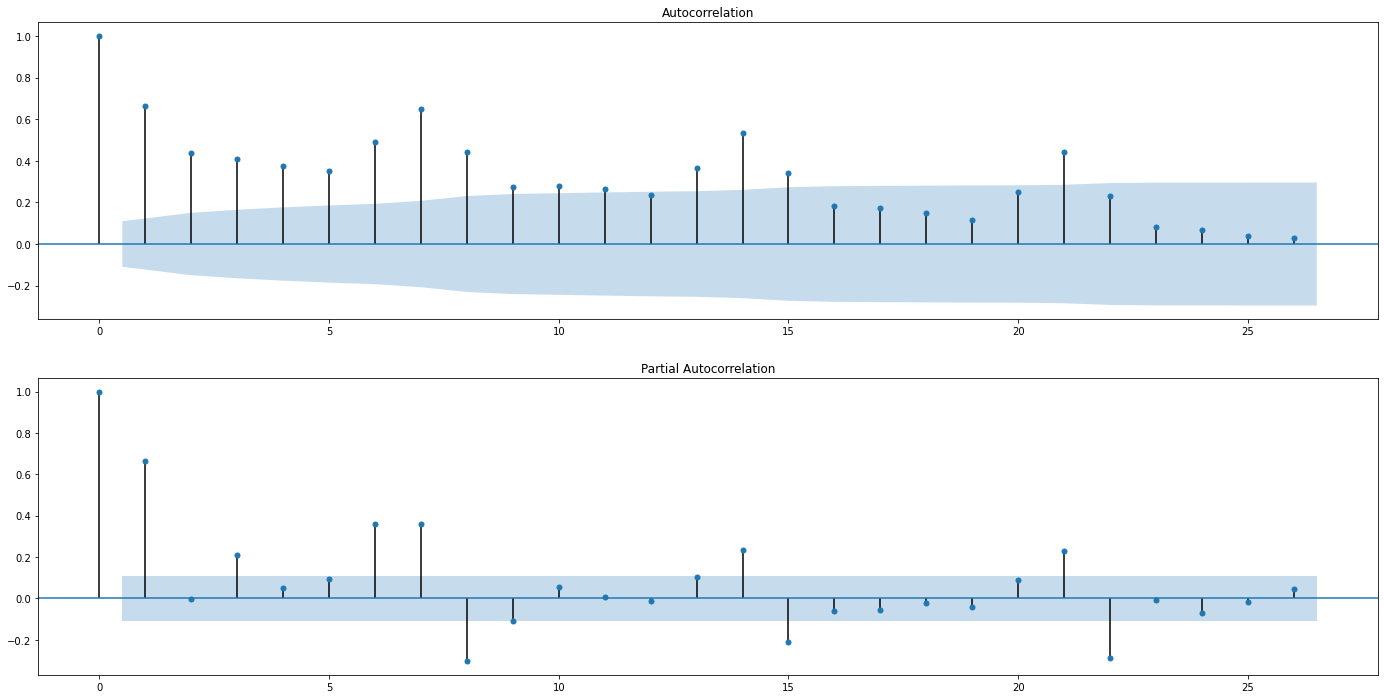

In [ ]:
fig, ax = plt.subplots(2, figsize=(24,12))
ax[0] = smg.tsaplots.plot_acf(mobility_campinas_workplace, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(mobility_campinas_workplace, ax=ax[1])

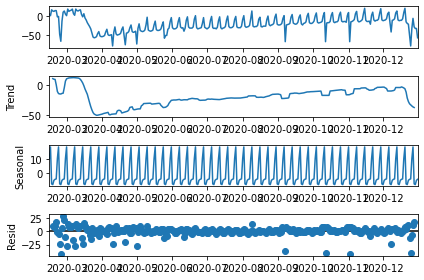

In [ ]:
decomposition_confirmed = sma.tsa.seasonal_decompose(mobility_campinas_workplace)
fig_dec_confirmed = decomposition_confirmed.plot()
plt.show()

## Mobilidade para residência

Nesta seção observaremos a mobilidade para locais de residência

In [ ]:
cols_residential = ['date', 'residential_percent_change_from_baseline']
mobility_residential = mobility_campinas[cols_residential]

In [ ]:
mobility_residential['date'] = mobility_residential.loc[:,'date'].astype('datetime64[ns]')
mobility_residential = mobility_residential.set_index("date")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


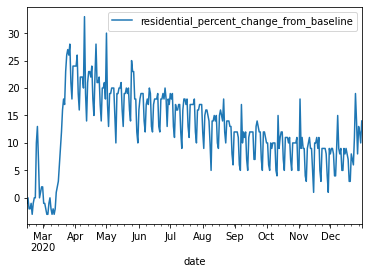

In [ ]:
mobility_residential.plot()
plt.show()

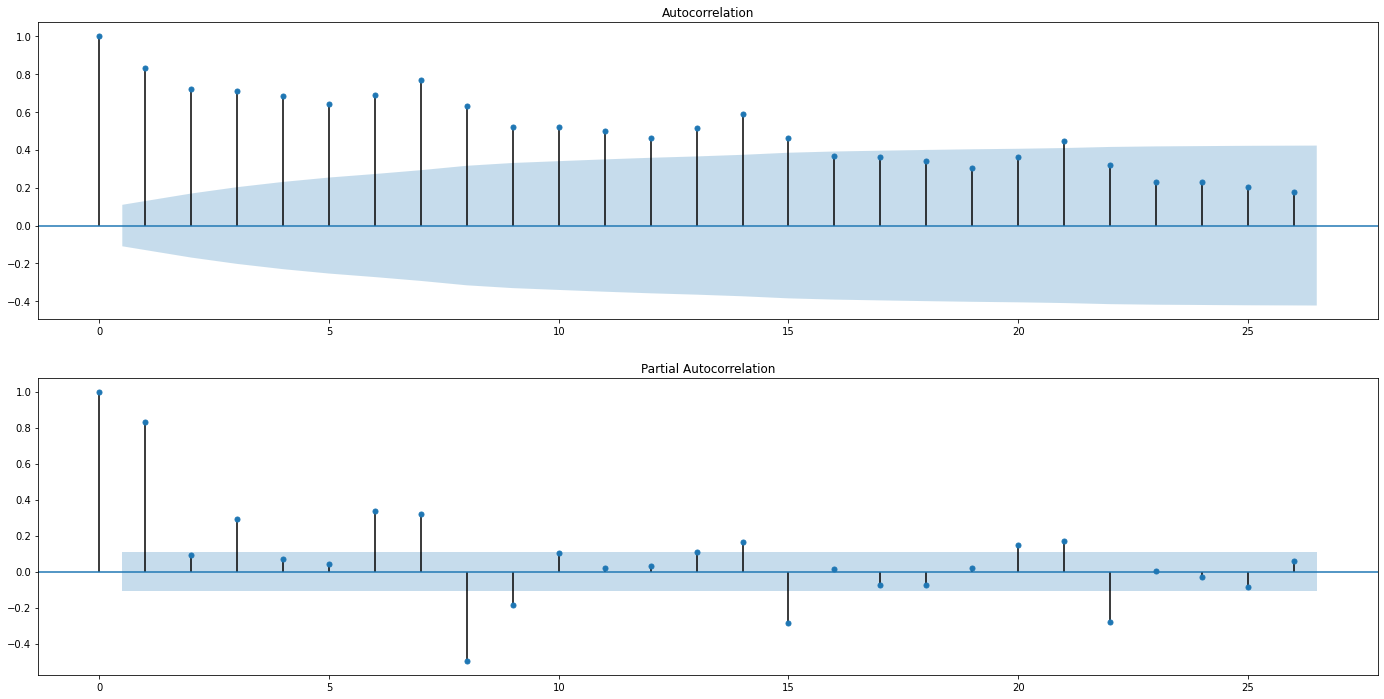

In [ ]:
fig, ax = plt.subplots(2, figsize=(24,12))
ax[0] = smg.tsaplots.plot_acf(mobility_residential, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(mobility_residential, ax=ax[1])

Diferentemente dos outros pontos de mobilidade, a residencial tem um aumento repentino em março e depois tem uma queda constante na tendência. Também é possível observar um comportamento sazonal para estes dados.

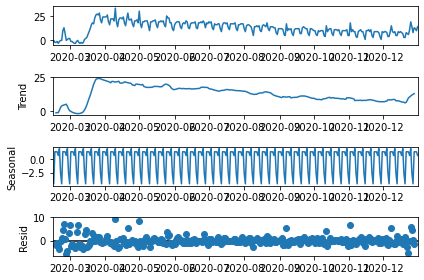

In [ ]:
decomposition_confirmed = sma.tsa.seasonal_decompose(mobility_residential)
fig_dec_confirmed = decomposition_confirmed.plot()
plt.show()

# Casos de covid em **campinas**

## Leitura de dados

In [ ]:
casos_sao_paulo_data = pd.read_csv('casos_sao_paulo.csv', engine='python', sep=';')

In [ ]:
casos_sao_paulo_data.head(5)

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
0,Adamantina,3500105,25,2,25/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Presidente Prudente,9,Mar�lia,5,33894,7398,41199,0,8.0,"-21,682","-51,0737",9
1,Adolfo,3500204,25,2,25/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de S�o Jos� do Rio Preto,14,S�o Jos� do Rio Preto,15,3447,761,21106,0,8.0,"-21,2325","-49,6451",9
2,Agua�,3500303,25,2,25/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,S�o Jo�o da Boa Vista,14,35608,5245,47455,0,8.0,"-22,0572","-46,9735",9
3,�guas da Prata,3500402,25,2,25/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,S�o Jo�o da Boa Vista,14,7797,1729,14267,0,8.0,"-21,9319","-46,7176",9
4,�guas de Lind�ia,3500501,25,2,25/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,18374,3275,6013,0,8.0,"-22,4733","-46,6314",9


In [ ]:
booleans = casos_sao_paulo_data['codigo_ibge'] == 3509502
filter_campinas = pd.Series(booleans)

campinas_casos = casos_sao_paulo_data[filter_campinas]
campinas_casos.head(10)

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
108,Campinas,3509502,25,2,25/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",9
753,Campinas,3509502,26,2,26/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",9
1398,Campinas,3509502,27,2,27/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",9
2043,Campinas,3509502,28,2,28/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",9
2688,Campinas,3509502,29,2,29/02/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",9
3333,Campinas,3509502,1,3,01/03/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",10
3978,Campinas,3509502,2,3,02/03/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",10
4623,Campinas,3509502,3,3,03/03/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",10
5268,Campinas,3509502,4,3,04/03/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",10
5913,Campinas,3509502,5,3,05/03/2020,0,0,"0,00E+00",0,0,0,"0,00E+00",0,0,RA de Campinas,4,Campinas,3,1175501,192796,79457,0,8.0,"-22,9053","-47,0659",10


## Análise de casos novos

In [ ]:
colunas_interesse = ['datahora', 'casos_novos']
campinas_casos_filtrados = campinas_casos[colunas_interesse]
campinas_casos_filtrados

,datahora,casos_novos
108,25/02/2020,0
753,26/02/2020,0
1398,27/02/2020,0
2043,28/02/2020,0
2688,29/02/2020,0
...,...,...
260043,03/04/2021,88
260688,04/04/2021,75
261333,05/04/2021,63
261978,06/04/2021,520


In [ ]:
campinas_casos_filtrados['datahora'] = pd.to_datetime(campinas_casos_filtrados.loc[:, 'datahora'], format='%d/%m/%Y')
campinas_casos_filtrados['datahora'] = campinas_casos_filtrados.loc[:, 'datahora'].astype('datetime64[ns]')
campinas_casos_filtrados = campinas_casos_filtrados.set_index("datahora")
campinas_casos_filtrados = campinas_casos_filtrados.sort_index().asfreq(freq='D', method='pad')
campinas_casos_filtrados.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DatetimeIndex(['2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03',
               '2020-03-04', '2020-03-05',
               ...
               '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01',
               '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05',
               '2021-04-06', '2021-04-07'],
              dtype='datetime64[ns]', name='datahora', length=408, freq='D')

<function matplotlib.pyplot.show>

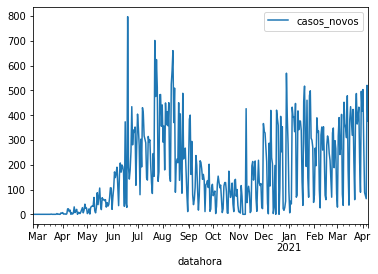

In [ ]:
campinas_casos_filtrados.plot()
plt.show

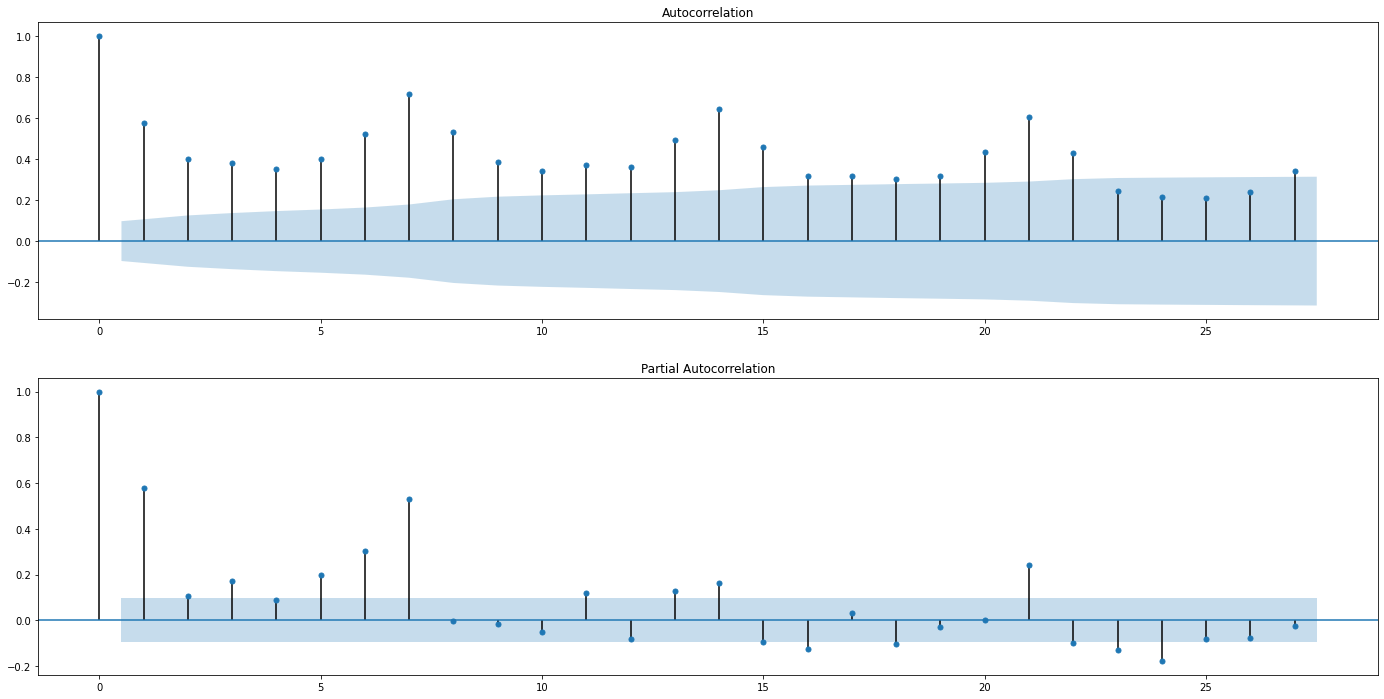

In [ ]:
fig, ax = plt.subplots(2, figsize=(24, 12))
ax[0] = smg.tsaplots.plot_acf(campinas_casos_filtrados, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(campinas_casos_filtrados, ax=ax[1])

<function matplotlib.pyplot.show>

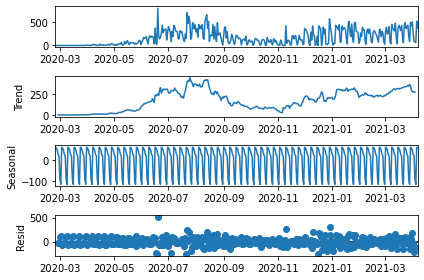

In [ ]:
decomposition_campinas_casos_filtrado = sma.tsa.seasonal_decompose(campinas_casos_filtrados)
fig_decomposition = decomposition_campinas_casos_filtrado.plot()
plt.show

## Análise de óbitos novos

In [ ]:
colunas_interesse = ['datahora', 'obitos_novos']
campinas_casos_filtrados = campinas_casos[colunas_interesse]
campinas_casos_filtrados

,datahora,obitos_novos
108,25/02/2020,0
753,26/02/2020,0
1398,27/02/2020,0
2043,28/02/2020,0
2688,29/02/2020,0
...,...,...
260043,03/04/2021,7
260688,04/04/2021,0
261333,05/04/2021,6
261978,06/04/2021,67


In [ ]:
campinas_casos_filtrados['datahora'] = pd.to_datetime(campinas_casos_filtrados.loc[:, 'datahora'], format='%d/%m/%Y')
campinas_casos_filtrados['datahora'] = campinas_casos_filtrados.loc[:, 'datahora'].astype('datetime64[ns]')
campinas_casos_filtrados = campinas_casos_filtrados.set_index("datahora")
campinas_casos_filtrados = campinas_casos_filtrados.sort_index().asfreq(freq='D', method='pad')
campinas_casos_filtrados.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DatetimeIndex(['2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03',
               '2020-03-04', '2020-03-05',
               ...
               '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01',
               '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05',
               '2021-04-06', '2021-04-07'],
              dtype='datetime64[ns]', name='datahora', length=408, freq='D')

<function matplotlib.pyplot.show>

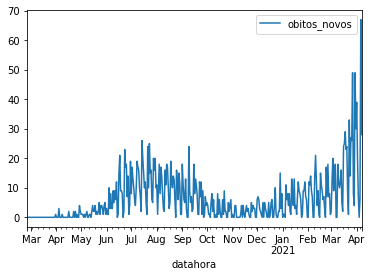

In [ ]:
campinas_casos_filtrados.plot()
plt.show

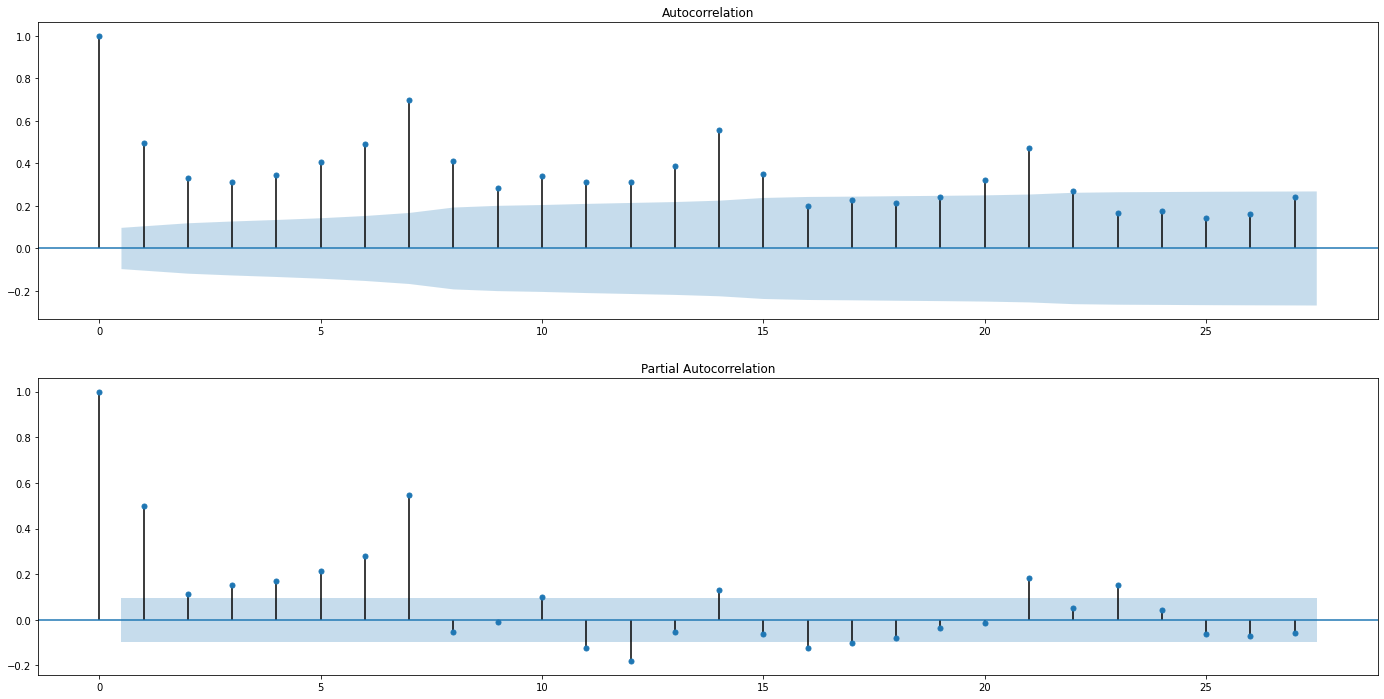

In [ ]:
fig, ax = plt.subplots(2, figsize=(24, 12))
ax[0] = smg.tsaplots.plot_acf(campinas_casos_filtrados, ax=ax[0])
ax[1] = smg.tsaplots.plot_pacf(campinas_casos_filtrados, ax=ax[1])

<function matplotlib.pyplot.show>

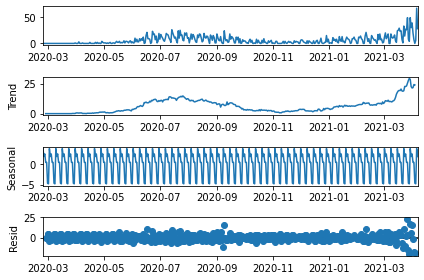

In [ ]:
decomposition_campinas_casos_filtrado = sma.tsa.seasonal_decompose(campinas_casos_filtrados)
fig_decomposition = decomposition_campinas_casos_filtrado.plot()
plt.show